# Transfer Learning for predicting Pneumonia (VGG16) 

## Pneumonia

Source : Wikipedia

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli. Typically symptoms include some combination of productive or dry cough, chest pain, fever, and troubled breathing. Severity is variable.

Pneumonia affects approximately 450 million people globally (7% of the population) and results in about 4 million deaths per year.

In 2008, pneumonia occurred in approximately 156 million children (151 million in the developing world and 5 million in the developed world). In 2010, it resulted in 1.3 million deaths, or 18% of all deaths in those under five years, of which 95% occurred in the developing world.


## Data 

Data for this project is downloaded from  Kaggle (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) and it contains 5863 images taken from pediatric patients ranging from 1 to 5 year olds.  The images are labelled by specialists in two classes: Normal and Pneumonia. 

The initial dataset was actually published here:  [Mendeley Data - Chest X-Ray Images](https://data.mendeley.com/datasets/rscbjbr9sj/2) 

Lets train a neural network to recognize the Pneumonia from the normal cases. 

We will start by loading the necessary libraries. 

In [1]:
import os
import shutil
import glob
import urllib.request

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 

Let's see what the data actually holds. We see three directories: test, train and the validaton sets

In [2]:
 glob.glob('../input/chest-xray-pneumonia/chest_xray/chest_xray/*/*')

['../input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA',
 '../input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL',
 '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA',
 '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL',
 '../input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA',
 '../input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL']

Below let's look at the data and vizualise some images: either normal or with pneumonia

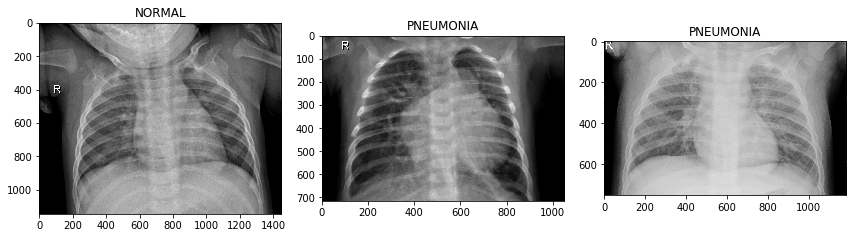

In [3]:
img_normal = plt.imread('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1017_bacteria_2948.jpeg')
img_penumonia_virus = plt.imread('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1021_virus_1711.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

In [4]:
def get_labeled_files(folder):
    x = []
    y = []
    
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                continue # we do not investigate other dirs
            for image_filename in os.listdir(folder + folderName):
                img_path = folder + folderName + '/' + image_filename
                if img_path is not None and str.endswith(img_path, 'jpeg'):
                    x.append(img_path)
                    y.append(label)
    
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

Now lets see some examples of what we have just done. 

In [5]:
x, y = get_labeled_files('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/')

list(zip(x, y))[:10]

[('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person957_virus_1629.jpeg',
  1),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1372_bacteria_3498.jpeg',
  1),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1284_bacteria_3247.jpeg',
  1),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person439_virus_891.jpeg',
  1),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person501_bacteria_2113.jpeg',
  1),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1559_bacteria_4067.jpeg',
  1),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1001_bacteria_2932.jpeg',
  1),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person739_virus_1361.jpeg',
  1),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1644_bacteria_4357.jpeg',
  1),
 ('../input/chest-xray-pneumonia/

As the Dataset has been matched we need to read and decode the jpeg files. we are doing that with the function below. Once that is done we need to also resize the images to something that our VGG16 can actually understand. 

In [6]:
NUM_CLASSES = 2

# This function takes image paths as arguments and reads corresponding images
def input_parser(img_path, label):
    # convert the label to one-hot encoding
    one_hot = tf.one_hot(label, NUM_CLASSES)
    # read the img from file and decode it using tf
    img_file = tf.read_file(img_path)
    img_decoded = tf.image.decode_jpeg(img_file, channels=3, name="decoded_images")
    return img_decoded, one_hot

# This function takes image and resizes it to smaller format (150x150)
def image_resize(images, labels):
    resized_image = tf.image.resize_images(images, (150, 150), align_corners=True)
    resized_image_asint = tf.cast(resized_image, tf.int32)
    return resized_image_asint, labels    

Create the pipeline in TF, moving from images to tensors. 

In [7]:
# Execution plan is defined here.
# Since it uses lazy evaluation, the images will not be read after calling build_pipeline_plan()
# We need to use iterator defined here in tf context
def build_pipeline_plan(img_paths, labels, batch_size):

    # We build a tensor of image paths and labels
    tr_data = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    # First step of input pipeline - read images in paths as jpegs
    tr_data_imgs = tr_data.map(input_parser)
    # Apply resize to each image in the pipeline
    tr_data_imgs = tr_data_imgs.map(image_resize)
    # Gives us opportuinty to batch images into small groups
    tr_dataset = tr_data_imgs.batch(batch_size)
    # create TensorFlow Iterator object directly from input pipeline
    iterator = tr_dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    return next_element

# Function to execute defined pipeline in Tensorflow session
def process_pipeline(next_element):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # get each element of the training dataset until the end is reached
        # in our case only one iteration since we read everything as 1 batch
        # can be multiple iterations if we decrease BATCH_SIZE to eg. 10
        images = []
        labels_hot = []
        while True:
            try:
                elem = sess.run(next_element)
                images = elem[0]
                labels_hot = elem[1]
            except tf.errors.OutOfRangeError:
                print("Finished reading the dataset")
                return images, labels_hot

Load the dataset and return it into images and labels. 

In [8]:
def load_dataset(path, batch_size):
    tf.reset_default_graph()
    files, labels = get_labeled_files(path)
    p = tf.constant(files, name="train_imgs")
    l = tf.constant(labels, name="train_labels")
    
    next_element = build_pipeline_plan(p, l, batch_size=batch_size)
    imgs, labels = process_pipeline(next_element)
    return imgs, labels

Lets check what we have done.

In [9]:
x_train, y_train = load_dataset("../input/chest-xray-pneumonia/chest_xray/chest_xray/train/", 6000)
x_test, y_test = load_dataset("../input/chest-xray-pneumonia/chest_xray/chest_xray/test/", 6000)
x_val, y_val = load_dataset("../input/chest-xray-pneumonia/chest_xray/chest_xray/val/", 6000)

Finished reading the dataset
Finished reading the dataset
Finished reading the dataset


Print the different sizes of the datasets. How images we have in each. 

In [10]:
print("Training Dataset")
print(x_train.shape)
print(y_train.shape)
print("\nTesting Dataset")
print(x_test.shape)
print(y_test.shape)
print("\n Validation  Dataset")
print(x_val.shape)
print(y_val.shape)

Training Dataset
(5216, 150, 150, 3)
(5216, 2)

Testing Dataset
(624, 150, 150, 3)
(624, 2)

 Validation  Dataset
(16, 150, 150, 3)
(16, 2)


Lets calculate what we have in each Dataset. 

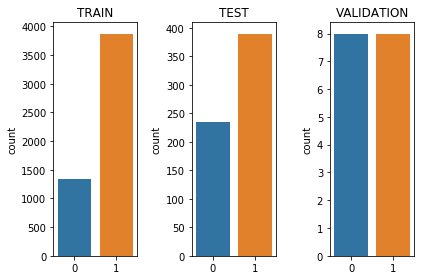

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.subplot(1,3,1)
sns.countplot(np.argmax(y_train, axis=1)).set_title('TRAIN')

plt.subplot(1,3,2)
sns.countplot(np.argmax(y_test, axis=1)).set_title('TEST')

plt.subplot(1,3,3)
sns.countplot(np.argmax(y_val, axis=1)).set_title('VALIDATION')

plt.tight_layout()


Final investigation. Lets see what we have before we start training.

(5216, 150, 150, 3)


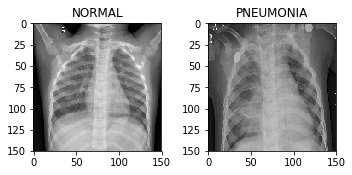

In [12]:
print(x_train.shape)

plt.figure(figsize=(5, 3))

y_train_classes = np.argmax(y_train, axis = 1)

plt.subplot(1,2,1).set_title('NORMAL')
plt.imshow(x_train[np.argmax(y_train_classes == 0)])

plt.subplot(1,2,2).set_title('PNEUMONIA')
plt.imshow(x_train[np.argmax(y_train_classes == 1)])

plt.tight_layout()

##The Neural Network 

Its time to take it from the very beginning and start with downloading the VGG16 network. 
The VGG16 network contains the weights trained for solving the ImageNet challenge. 

Next, we'll replace the orignal classification layer and build a new one

It will be composed of:

- Flatten transformation that reshapes the MaxPool output (4 x 4 x 512) into (1 x 1 x 8192)
- Fully Connected Dense layer with Softmax activation function with 2 outputs (1 x 1 x 2)

Softmax function normalizes input vector into a probability distribution that sums to 1.0

In [13]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16
#from keras.applications.vgg19 import VGG19
#from keras.applications.densenet import DenseNet
from keras.applications.inception_v3 import InceptionV3

K.clear_session()

NUM_CLASSES = 2

base_model = VGG16(weights='../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(150, 150, 3))
#base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
#base_model = DenseNet(blocks=10, weights='imagenet', include_top=False, input_shape=(150, 150, 3))
#base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

This network has over 14M trainable weights.

In [14]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

We would like to train only the most bottom classifier layers.

In [15]:
for layer in model.layers[0:18]:
    layer.trainable = False
    
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_pool, trainable: False
layer 11: block4_conv1, trainable: False
layer 12: block4_conv2, trainable: False
layer 13: block4_conv3, trainable: False
layer 14: block4_pool, trainable: False
layer 15: block5_conv1, trainable: False
layer 16: block5_conv2, trainable: False
layer 17: block5_conv3, trainable: False
layer 18: block5_pool, trainable: True
layer 19: flatten_1, trainable: True
layer 20: dense_1, trainable: True


In [16]:
model.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(8192, 2) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32_ref>]

[](http://)By locking the trainable layers we decrease the amount of trainable parameters to 16'384.

Here we use the "cross-entropy" loss function, which works well for learning probability distributions for classification. 

See e.g.: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy

In [17]:
import numpy as np
import keras.backend as K
from itertools import product
from functools import partial

In [18]:
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return K.categorical_crossentropy(y_pred, y_true) * final_mask


w_array = np.ones((2,2))
w_array[1,0] = 30 # penalizing FN
w_array[0,1] = 1 # penalizing FP

spec_loss = lambda y_true, y_pred: w_categorical_crossentropy(y_true, y_pred, weights=w_array)

In [19]:
# Create the loss function object using the wrapper function abov
optimizer = keras.optimizers.Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',     #  loss=spec_loss,
              optimizer=optimizer, 
              metrics=['accuracy'])

In [20]:
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

# This callback saves the wieights of the model after each epoch
checkpoint = ModelCheckpoint(
    'model/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# This callback writes logs for TensorBoard
tensorboard = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0,  
    write_graph=True
)

The training set is un-balanced. Let's calculate class weights

In [21]:
from sklearn.utils import class_weight
y_labels = np.argmax(y_train, axis=1)
classweight = class_weight.compute_class_weight('balanced', np.unique(y_labels), y_labels)
print(classweight)

[1.9448173  0.67303226]


In [22]:
# prepare a directory to store the model weights
os.makedirs('./model', exist_ok=True)

history = model.fit(
    x=x_train, y=y_train,
    class_weight=classweight,
    validation_split=0.3,
    callbacks=[tensorboard],
    shuffle=True,
    batch_size=256,
    epochs=60,
    verbose=1
)

Instructions for updating:
Use tf.cast instead.
Train on 3651 samples, validate on 1565 samples
Epoch 1/60
3651/3651 [==============================] - 15s 4ms/step - loss: 0.0821 - acc: 0.9871 - val_loss: 13.8111 - val_acc: 0.1431
Epoch 2/60
3651/3651 [==============================] - 9s 2ms/step - loss: 4.8075e-04 - acc: 0.9997 - val_loss: 13.8111 - val_acc: 0.1431
Epoch 3/60
3651/3651 [==============================] - 9s 2ms/step - loss: 1.6693e-07 - acc: 1.0000 - val_loss: 13.8111 - val_acc: 0.1431
Epoch 4/60
3651/3651 [==============================] - 9s 2ms/step - loss: 1.3932e-07 - acc: 1.0000 - val_loss: 13.8111 - val_acc: 0.1431
Epoch 5/60
3651/3651 [==============================] - 9s 2ms/step - loss: 1.3333e-07 - acc: 1.0000 - val_loss: 13.8111 - val_acc: 0.1431
Epoch 6/60
3651/3651 [==============================] - 9s 2ms/step - loss: 1.3227e-07 - acc: 1.0000 - val_loss: 13.8111 - val_acc: 0.1431
Epoch 7/60
3651/3651 [==============================] - 9s 2ms/step - los

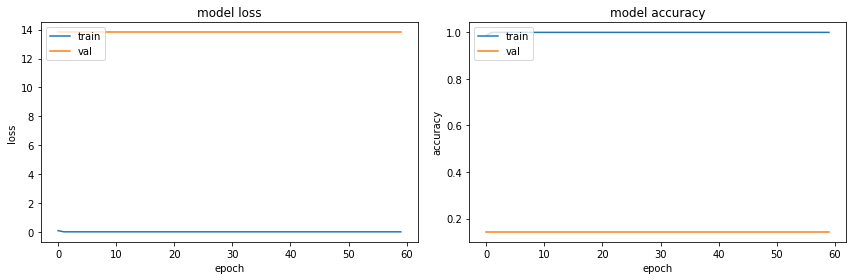

In [23]:
def plot_learning_curves(history):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    
plot_learning_curves(history)

Measure Loss and Accuracy on the test dataset

In [24]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 6.044285872043716, Accuracy: 0.625


## Looking at performance 

Lets use confusion matrix for analyzing the performance. 

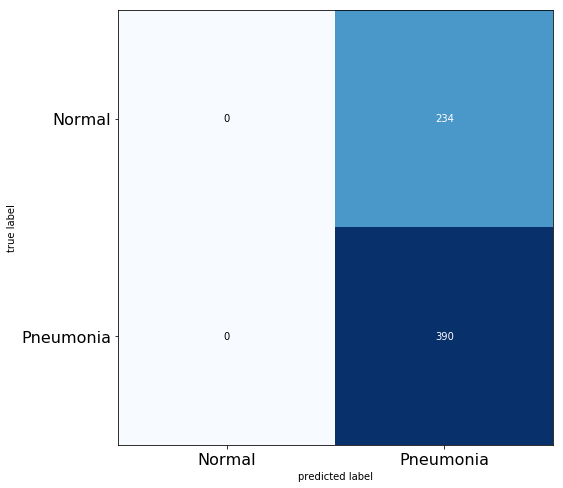

In [25]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_pred = model.predict(x_test)
# to get the prediction, we pick the class with with the highest probability
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 


conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

** ROC curve

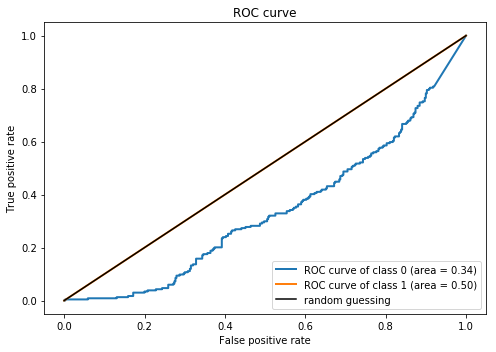

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
                                 
plt.figure(figsize=(7, 5))

for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
plt.plot(fpr[0], fpr[0], 'k-', label = 'random guessing')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.tight_layout()

**Things to do next**: 
* To achieve better performance, try tuning hyperparameters i.e. learning rate etc.
* Try to use another base network i.e. InceptionV3, ResNet50, DenseNet.
* Try training some CONV layers, see if this helps?